In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
!git clone https://github.com/superring/topic_model.git

Cloning into 'topic_model'...
remote: Enumerating objects: 8363, done.
remote: Counting objects: 100% (8363/8363), done.
remote: Compressing objects: 100% (8261/8261), done.
remote: Total 8363 (delta 98), reused 8352 (delta 90), pack-reused 0
Receiving objects: 100% (8363/8363), 31.84 MiB | 21.20 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [20]:
!pip install -r ./topic_model/requirements.txt

     |████████████████████████████████| 13.1MB 312kB/s 
  Using cached https://files.pythonhosted.org/packages/c1/72/20f8f60b858556fdff6c0376b480c230e594621fff8be780603ac9c47f6a/mecab_python3-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.4.2
    Uninstalling matplotlib-3.4.2:
      Successfully uninstalled matplotlib-3.4.2
  Found existing installation: mecab-python3 0.996.3
    Uninstalling mecab-python3-0.996.3:
      Successfully uninstalled mecab-python3-0.996.3


In [3]:
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.3
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl lib

In [4]:
import glob
import urllib
import MeCab
import subprocess
import gensim
import math
import matplotlib
import matplotlib.pylab as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
FONT = "./topic_model/ArialUnicodeMS.ttf"

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
# ニュースのテキストファイルのパス
text_paths = glob.glob('./topic_model/text/**/*.txt')

# 形態素解析用のストップワードの定義
req = urllib.request.Request('http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt')
with urllib.request.urlopen(req) as res:
    stopwords = res.read().decode('utf-8').split('\r\n')
while '' in stopwords:
    stopwords.remove('')

In [13]:
# 形態素解析用の関数定義。固有名詞、名詞、動詞、形容詞を中心に
def analyzer(text, mecab, stopwords=[], target_part_of_speech=['proper_noun', 'noun', 'verb', 'adjective']):
    node = mecab.parseToNode(text)
    words = []
    while node:
        features = node.feature.split(',')
        surface = features[6]
        if (surface == '*') or (len(surface) < 2) or (surface in stopwords):
            node = node.next
            continue
        noun_flag = (features[0] == '名詞')
        proper_noun_flag = (features[0] == '名詞') & (features[1] == '固有名詞')
        verb_flag = (features[0] == '動詞') & (features[1] == '自立')
        adjective_flag = (features[0] == '形容詞') & (features[1] == '自立')
        if ('proper_noun' in target_part_of_speech) & proper_noun_flag:
            words.append(surface)
        elif ('noun' in target_part_of_speech) & noun_flag:
            words.append(surface)
        elif ('verb' in target_part_of_speech) & verb_flag:
            words.append(surface)
        elif ('adjective' in target_part_of_speech) & adjective_flag:
            words.append(surface)
        node = node.next
    return words


In [14]:
# LDAのための辞書とコーパス作成
cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
mecab = MeCab.Tagger("-d {0}".format(path))

titles = []
texts = []
for text_path in text_paths:

    text = open(text_path, 'r').read()
    text = text.split('\n')
    title = text[2]
    text = ' '.join(text[3:])
    words = analyzer(text, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])
    texts.append(words)
    

dictionary = gensim.corpora.Dictionary(texts)
# 出現回数3未満、出現割合50%以上の単語を削除
dictionary.filter_extremes(no_below=3, no_above=0.5)
corpus = [dictionary.doc2bow(t) for t in texts]


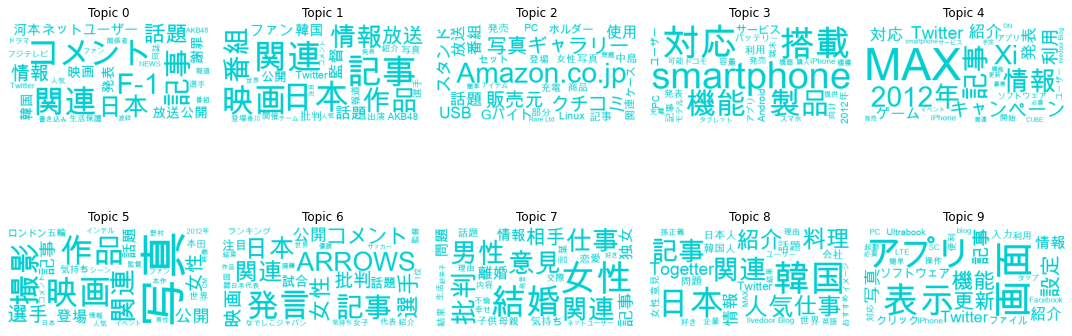

In [21]:
# LDAモデリングの実行
num_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=0)
# 可視化
ncols = math.ceil(num_topics/2)
nrows = math.ceil(lda_model.num_topics/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,7))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i in range(lda_model.num_topics):

    x = dict(lda_model.show_topic(i, 30))
    im = WordCloud(font_path=FONT, background_color='white', color_func=color_func, random_state=0).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(i))

plt.tight_layout()
plt.savefig("./visualize.png")

In [ ]:
# pyLDAvisによる可視化
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis, './pyldavis_output.html')

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 予測
def topic_prediction(string_input):

    # Fit and transform
    words = analyzer(string_input, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])
 
    # コーパス作成
    corpus = [dictionary.doc2bow(words)]
 
    output = list(lda_model[corpus])[0]
    topics = sorted(output,key=lambda x:x[1],reverse=True)
    return topics[0][0]
    #return output
  



/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 予測
topic_prediction("2012年に映像革命が起こる、『ロード・オブ・ザ・リング』の前章『ホビット』の公開が決定『ハリー・ポッター』シリーズのワーナー・ブラザーズ映画と『ロード・オブ・ザ・リング』3部作のピーター・ジャクソン監督がタッグを組み、映画『ホビット』2部作の公開を決定した。また、公開日と邦題も決定し、新たなる傑作への期待が高まる。本作は、ホビット族のビルボ・バギンズの旅が描かれている。ビルボは、ドラゴンに支配され失われてしまったエレボールのドワーフ王国の再建をかけ、壮大な冒険の旅へ出る。ある時、伝説的な戦士トーリン・オーケンシールド率いる13人のドワーフから成る一団に参加することになった。目的地へ向かう途中、ビルボは、自身の人生を永遠に変えてしまうクリーチャーのゴクリ（※『ロード・オブ・ザ・リング』3部作では、ゴラム）と出会う。そこで、有用な性質を持つゴクリ（ゴラム）の“いとしいしと”と呼ばれるリングをも手に入れる。そのリングは、ビルボが知り得ない中つ国（ミドル・アース）全ての運命と深く結びついていた。")

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7

ここまでは記事単位でトピックを作りましたが、文章単位でトピックも作ってみる

In [23]:
# LDAのための辞書とコーパス作成
texts = []
for text_path in text_paths:

    text = open(text_path, 'r').read()
    text = text.split('\n')
    title = text[2]
    text = ' '.join(text[3:])
    # 記事を句読点で区切る
    sentences = text.split('。')
    for sentence in sentences:
        words = analyzer(sentence, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])
        texts.append(words)
    

dictionary = gensim.corpora.Dictionary(texts)
# 出現割合80%以上の単語を削除
dictionary.filter_extremes(no_below=0, no_above=0.8)
corpus = [dictionary.doc2bow(t) for t in texts]
# LDAモデリングの実行
num_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=0)
# 可視化
ncols = math.ceil(num_topics/2)
nrows = math.ceil(lda_model.num_topics/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,7))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i in range(lda_model.num_topics):

    x = dict(lda_model.show_topic(i, 30))
    im = WordCloud(font_path=FONT, background_color='white', color_func=color_func, random_state=0).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(i))

plt.tight_layout()
plt.savefig("./visualize_by_sentence.png")

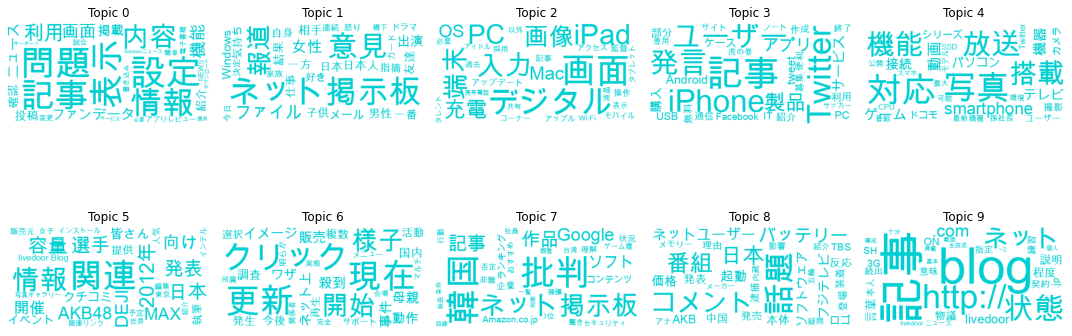